### Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### Loading Data

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/7thSemester/OnlineRetail.csv',sep=",", encoding="ISO-8859-1", header=0)

### Inspecting Data

In [6]:
df.shape

(541909, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [10]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.95,12680.0,France


## Data Preprocessing

In [12]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [13]:
df = df.dropna()
df.shape

(406829, 8)

**Note:** Hence no null or NA values in the dataset, (Dropped those which have null)

Changing datatype of Customer ID:

In [14]:
df['CustomerID'] = df['CustomerID'].astype(str)

### Data Preparation

We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [15]:
# Attribute: Monetory
df['Amount'] = df['Quantity']*df['UnitPrice']
rfm_m = df.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [16]:
# Attribute: Frequency
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [17]:
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [18]:
# Attribute: Recency
# Converting DateTime to proper Datatype
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [19]:
# Diff b/w max date and transaction date
df['Diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [ ]:
# Compute last transaction date to get the recency of customers
rfm_p = df.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

In [21]:
# We Need only No# of Days
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


**Note:** We have 3 columns, merging them to get the final dataframe

In [22]:
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


There are 2 types of outliers and we will treat outliers as it can skew our dataset¶
- Statistical
- Domain specific

### Outlier Analysis

Text(0.5, 0, 'Attributes')

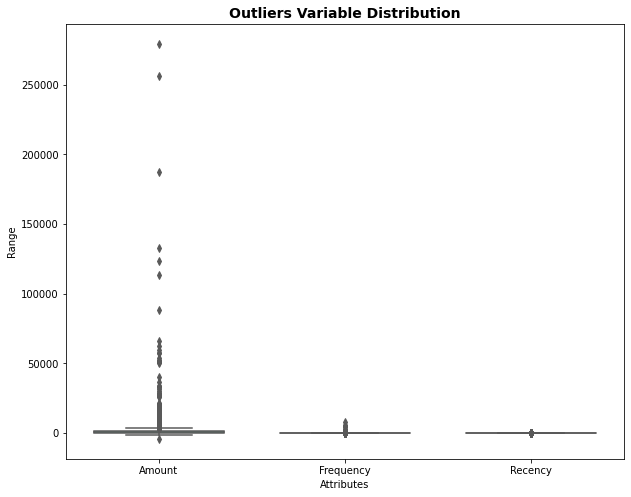

In [23]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range")
plt.xlabel("Attributes")

Removing Statistical Outliers (Using Q1 = 0.05 and Q3 = 0.95)

In [24]:
# Outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

Scaling Values, using Standarization (mean = 0, sigma = 1)

In [25]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()
# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [26]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## Modeling

### K Means Clustering

In [27]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [28]:
kmeans.labels_

array([0, 3, 1, ..., 0, 1, 1], dtype=int32)

#### Finding Optimal Number of Clusters (using Elbow Curve)

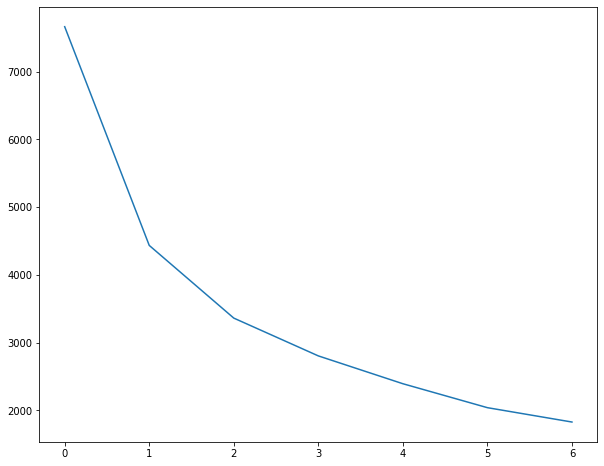

In [29]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

**Note:** Impact of 3 clusters is very on the data
Clustering with numOfClusters = 3

In [30]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)
kmeans.labels_

array([0, 1, 2, ..., 0, 2, 2], dtype=int32)

In [31]:
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0


##### Box Plot to Visualize ClusterID and Amount

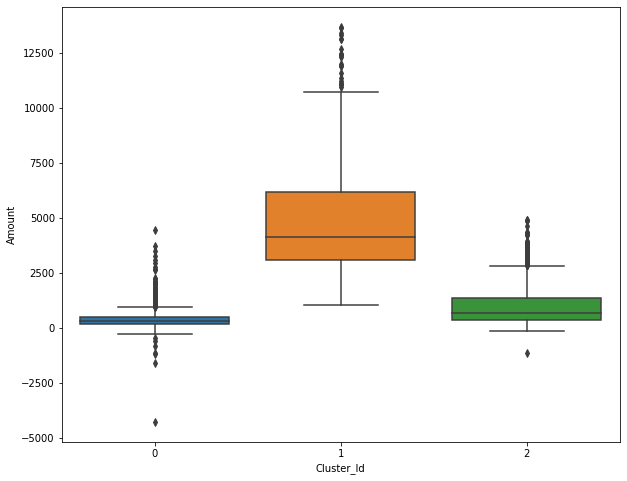

In [32]:
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

#### Box Plot to Visualize ClusterID and Frequency

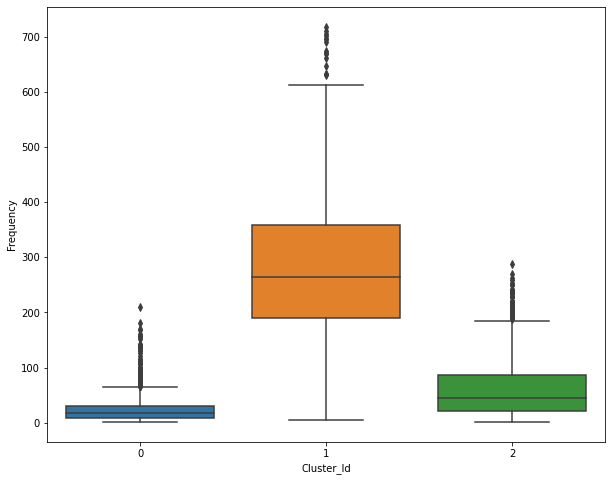

In [33]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

#### Box Plot to Visualize ClusterID and Recency

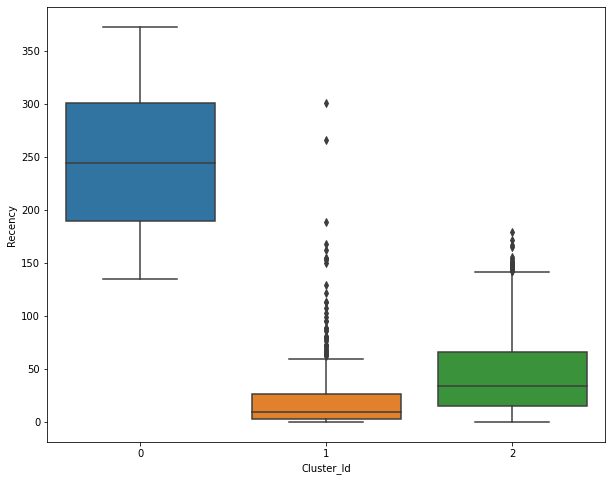

In [34]:
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering,

- Divisive
- Agglomerative.

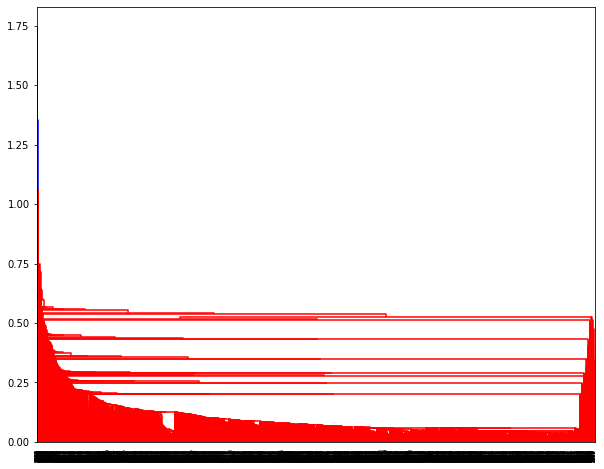

In [35]:
# Single Linkage Method (Closest Points)
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

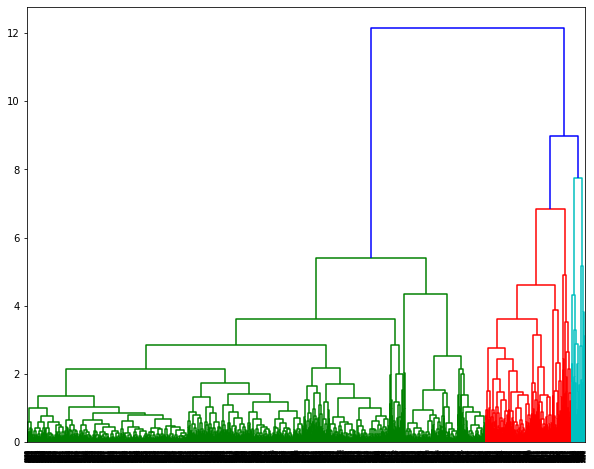

In [36]:
# Complete Linkage Method (Farthest Points)
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

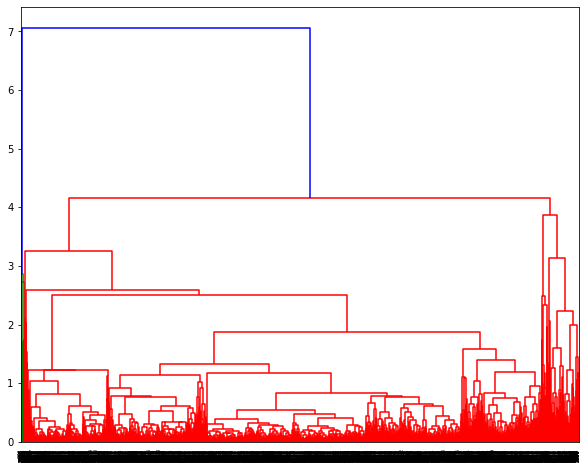

In [37]:
# Average Linkage Method (Mean Of All Points)
mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

#### Cutting the Dendogram Based On K

In [38]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,325,0,0
1,12347.0,4310.00,182,1,1,0
2,12348.0,1797.24,31,74,2,0
3,12349.0,1757.55,73,18,2,0
4,12350.0,334.40,17,309,0,0


### Plotting Clusters:


##### Plot ClusterID and Amount

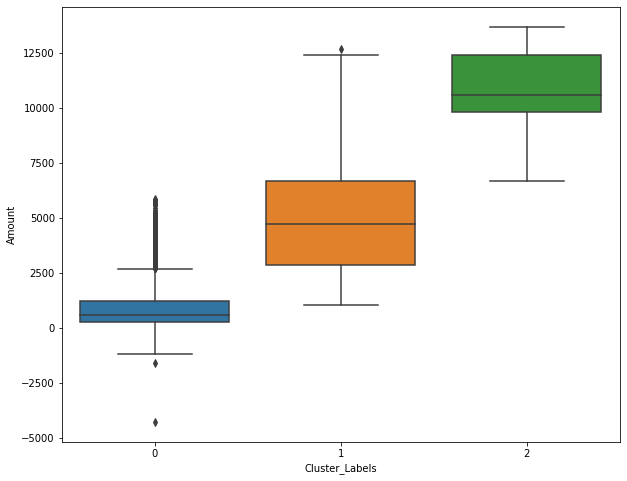

In [40]:
sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

##### Plot ClusterID and Frequency

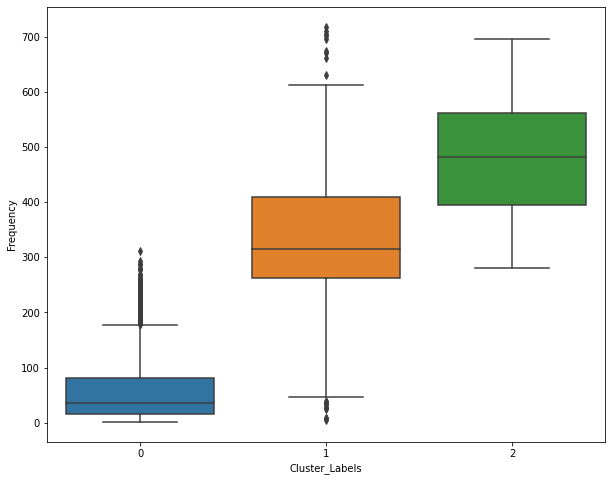

In [41]:
sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

##### Plot ClusterID and Recency

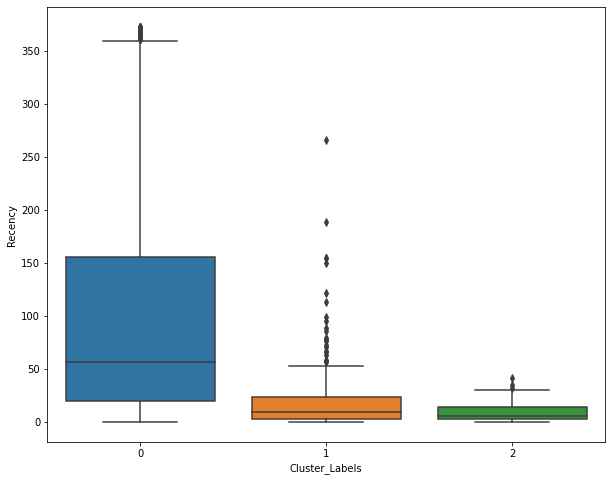

In [42]:
sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

## Inference

K-Means Clustering with 3 Cluster Ids

- Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 1 are frequent buyers.
- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.

Hierarchical Clustering with 3 Cluster Labels

- Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster_Labels 2 are frequent buyers.
- Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view